# IMDB part IV : the final chapter

In part <a href="https://github.com/GTouzin/Portfolio/blob/master/R/IMDB/IMDB_data_cleaning.ipynb">1</a>, <a href="https://github.com/GTouzin/Portfolio/blob/master/R/IMDB/IMDB_data_cleaning2.ipynb">2</a> and <a href="https://github.com/GTouzin/Portfolio/blob/master/R/IMDB/IMDB_data_exploration.ipynb">3</a> of this series of posts I cleaned, gathered and explored a data set of 5000 movies taken from IMDB by the Kaggle user deepMatrix. Now I will apply three different machine learning algorithms to create a model which will predict the profitability of a movie by looking at features that are available in pre-production. 

In the first part of this article, I will use the support machine vector algorithm, the XGBoost algorithm. Then, I'll use the XGBoost algorithm to label the movie as either profitable or non-profitable. Using this algorithm in both contexts will be a good occasion to talk about his limitation and how the formulation of a problem can affect the performance of a model.

As usual, the first thing I do is load the necessary library and the data set.

In [4]:
library(dplyr)
library(data.table)
library(bit64)
library(plotly)
library(corrplot)
options(scipen=999)
library(xgboost)
library(psych)
library(e1071)
library(neuralnet)

In [5]:
movies <- fread("movie_exploration.csv",stringsAsFactors = F)

Then I choose the variables I could use in the model and classify them by type. Remember that some variables in the data set are the measure of phenomena who should happen after the release of the movie, so they are useless for my model and I don't list them.

In [6]:
cont_var<-names(movies[,c("duration","director_facebook_likes","actor_3_facebook_likes","actor_1_facebook_likes",
                           "cast_total_facebook_likes","facenumber_in_poster","actor_2_facebook_likes","budget_2016",
                          "profit","gross_2016","dir_mean_gross","act_1_mean_gross","act_2_mean_gross","act_3_mean_gross")])

cath_var<-names(movies[,c("color","language","country","content_rating","title_year","aspect_ratio")])

genre_var<-names(movies[,c("genres_Action","genres_Adventure","genres_Animation","genres_Biography","genres_Comedy",
                        "genres_Crime","genres_Documentary","genres_Drama","genres_Family","genres_Fantasy","genres_Film_Noir",
                        "genres_Game_Show","genres_History","genres_Horror","genres_Music","genres_Musical","genres_Mystery",
                        "genres_News","genres_Reality_TV","genres_Romance","genres_Sci_Fi","genres_Short","genres_Sport",
                        "genres_Thriller","genres_War","genres_Western")])

Since most functions in R can't handle the categorical variable, I coded them using multiple dummy variables, like I did previously for the genre variable.

In [7]:
for (f in cath_var) {
    movies <- cbind(movies, dummy.code(movies[[f]]))
}

I created two sets of sample to train and test the different model. When needed, I will split the train data set to cross validate the model.

In [8]:
set.seed(383)
row_sample<-sample(1:nrow(movies),0.8*nrow(movies),replace=FALSE)
train<-movies[row_sample]
test<-movies[!row_sample]

# Regression
## SVM

The first algorithm I'll use is the support vector machine. I choose this algorithm since it's pretty versatile, capable of doing linear and non-linear regression and it's quite fast. So it's a perfect algorithm to do a base model. 

Since the efficiency of the SVM algorithm decrease with the number of dimensions of our model, I started by making a simple model with only a handful of variables and then made another more complex to see how what is the optimal number of variable to include in the model. The variables used are the one who had a correlation coefficient of at least 0.2 with the "gross_2016" variable. 

In [9]:
base.var<-names(movies[,c("duration","director_facebook_likes","actor_3_facebook_likes","budget_2016",
                          "dir_mean_gross","act_1_mean_gross","act_2_mean_gross","act_3_mean_gross", "gross_2016")])
train.svm.base<-train[,base.var,with=FALSE]
test.svm.base<-test[,base.var,with=FALSE]

train.svm.base<-train.svm.base[complete.cases(train.svm.base)]
test.svm.base<-test.svm.base[complete.cases(test.svm.base)]

Since the R function can scale the continuous variables, I can pass them directly as an argument without normalization.

In [10]:
model.svm.base <- svm(gross_2016~.,  scale = TRUE, data = train.svm.base)

In [11]:
resultats.svm.base <- predict(object = model.svm.base, newdata = train.svm.base)

I chose the root mean square error as a metric to measure the difference between the real values and our model prediction. R doesn't provide a function to calculate the rmse so I have written my own.

In [12]:
rmse <- function(error)
{
    sqrt(mean(error^2,na.rm=TRUE))
}

In [13]:
error <- train.svm.base$gross_2016 - resultats.svm.base
rmse(error) 

[1] 71758341

After doing a base model with the default parameter, I now must tune the model by choosing the best value of the parameter epsilon and the cost in the Lagrange transformation. Choosing a good value for those parameters will help the model fit the data without overfitting. I looked at the value of epsilon between 0 and 1 by increment of 0.1 and the cost value of 4 and 8. If needed, I'll look at other values.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
     0.3    4

- best performance: 6002111824269366 



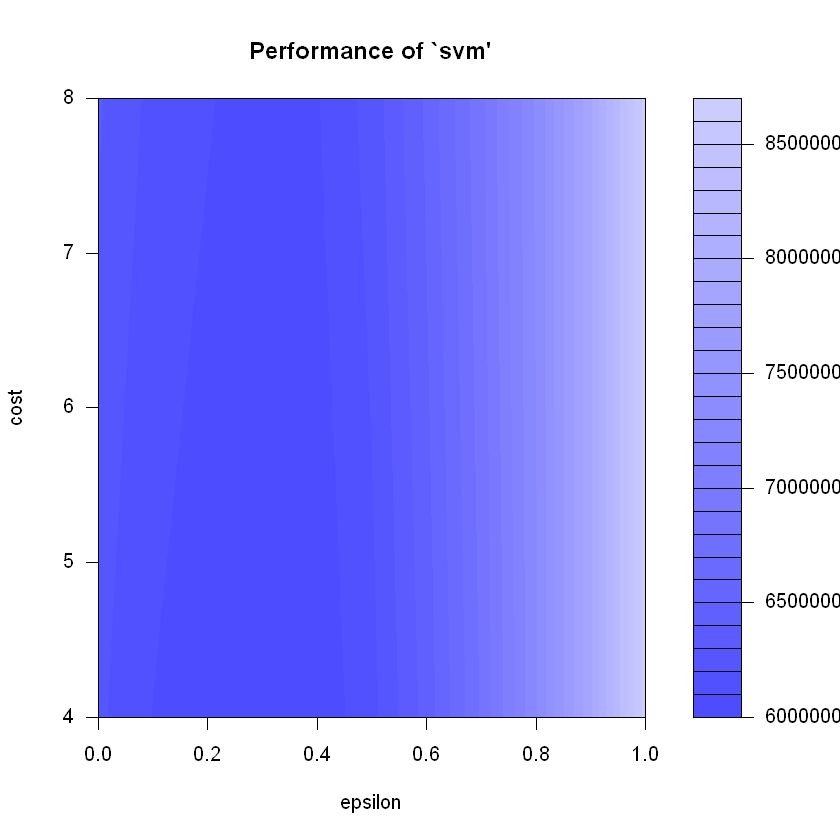

In [14]:
options(warn=-1)
set.seed(383)
svm.base.tune <- tune(svm, gross_2016~., data = train.svm.base,
              ranges = list(epsilon = seq(0,1,0.1), cost = 2^(2:3))
)
options(warn = 1)
print(svm.base.tune)
plot(svm.base.tune)

The darker area on this plot is the region where the optimal value of epsilon and cost is located. Since this region seems to be located between e=0.1, e=0.5 and cost<4, I searched deeper in this region.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
     0.3    2

- best performance: 6063056414748873 



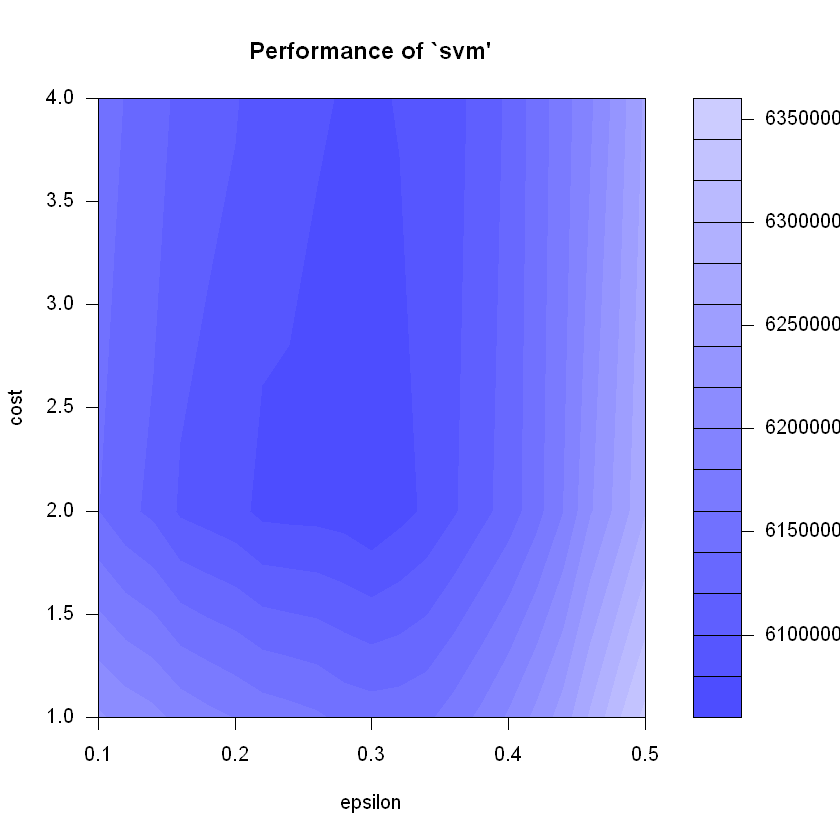

In [15]:
options(warn=-1)
svm.base.tune2 <- tune(svm, gross_2016~., data = train.svm.base,
              ranges = list(epsilon = seq(0.1,0.5,0.02), cost = 2^(0:2))
)
options(warn = 1)
print(svm.base.tune2)
plot(svm.base.tune2)

Now the region is more defined. Let focus on the region e=0.2, e=0.3, cost=1 and cost=4.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
    0.29    2

- best performance: 6071966176849776 



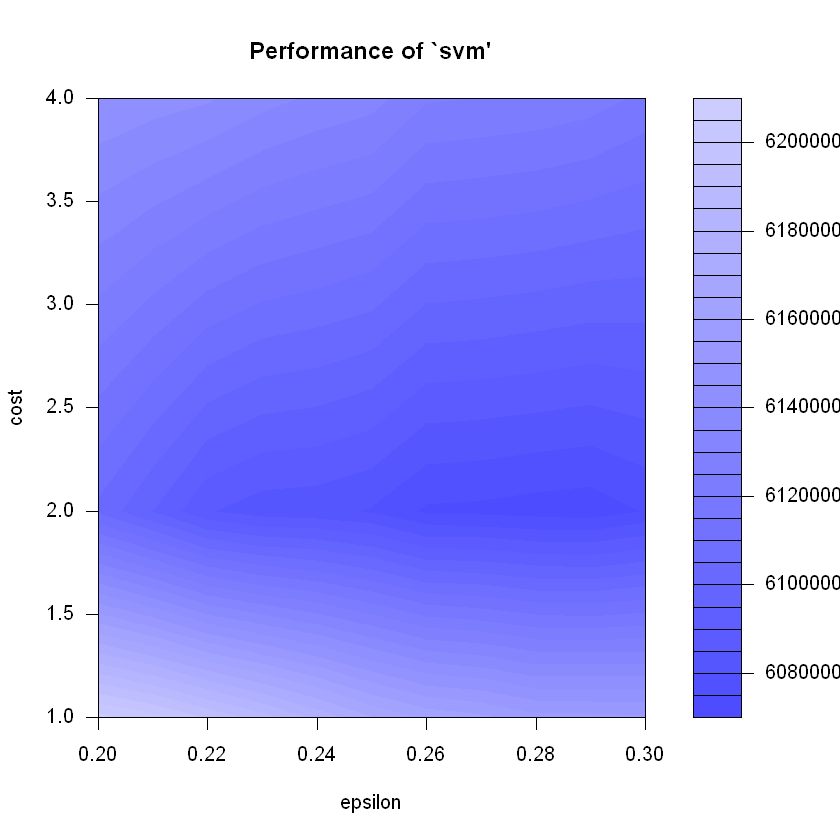

In [16]:
options(warn=-1)
svm.base.tune3 <- tune(svm, gross_2016~., data = train.svm.base,
              ranges = list(epsilon = seq(0.2,0.3,0.01), cost = 2^(0:2))
)
options(warn = 1)
print(svm.base.tune3)
plot(svm.base.tune3)

In [17]:
svm.base.tune3$best.model


Call:
best.tune(method = svm, train.x = gross_2016 ~ ., data = train.svm.base, 
    ranges = list(epsilon = seq(0.2, 0.3, 0.01), cost = 2^(0:2)))


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  2 
      gamma:  0.125 
    epsilon:  0.29 


Number of Support Vectors:  1189


Now that I have the optimal value of the hyperparameter, I can make the prediction for the test set.

In [18]:
model.svm.base.tune <- svm.base.tune3$best.model
model.svm.base.tune.pred <- predict(model.svm.base.tune, test.svm.base) 
 
error <- test.svm.base$gross_2016 - model.svm.base.tune.pred    
rmse(error) 

[1] 85547248

In [122]:
svm_base_pred<-plot_ly(test.svm.base) %>%
add_trace(y=~test.svm.base$gross_2016, name = 'test set', type = 'scatter',mode = 'lines+markers' )%>%
add_trace(y=~model.svm.base.tune.pred ,name = 'predictions', type = 'scatter',mode = 'markers' )%>%
layout(title = 'Gross revenu of movies and prediction from the svm algorithm',
         xaxis = list(title = '', zeroline = TRUE),
         yaxis = list(title = 'Gross'))

embed_notebook(svm_base_pred,file=paste0("plotlyJupyterHTML/","svm_base_pred",".html"))

In [20]:
write.svm(model.svm.base.tune , svm.file = "model.svm.base.tune.svm", scale.file = "IMDB-regression.scale")

We can see that the model has trouble predicting the outlier since most of the predicted point are between 0 and 200 million dollars. Also, if we zoom on any part of the plot, we see that the model is quite good at predicting the shape of the curve, but miss the real value of the variable "gross_2016". Let's see if adding more feature will help the model. 

In [21]:
train_svm<-train[,c(cont_var),with=FALSE]
test_svm<-test[,c(cont_var),with=FALSE]

After coping all the continuous variable in the data set, I drop the "profit" variables and I keep only the row without missing values.

In [22]:
train_svm <- train_svm[,!"profit",with=FALSE]
test_svm  <- test_svm[,!"profit",with=FALSE]

train_svm <- train_svm[complete.cases(train_svm)]
test_svm  <- test_svm[complete.cases(test_svm)]

In [23]:
model.svm.cont <- svm(gross_2016~.,  scale = TRUE, data = train_svm)

In [24]:
resultats.svm.cont <- predict(object = model.svm.cont, newdata = train_svm)

In [31]:
error <- train_svm$gross_2016 - resultats.svm.cont
rmse(error) 

[1] 72497905

Using all the continuous variables to the model doesn't make it more precise. Like most algorithms, the SVM algorithm is less accurate the more feature we use. Let's see if fine tuning the model can help.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
     0.3    4

- best performance: 6166321760868823 



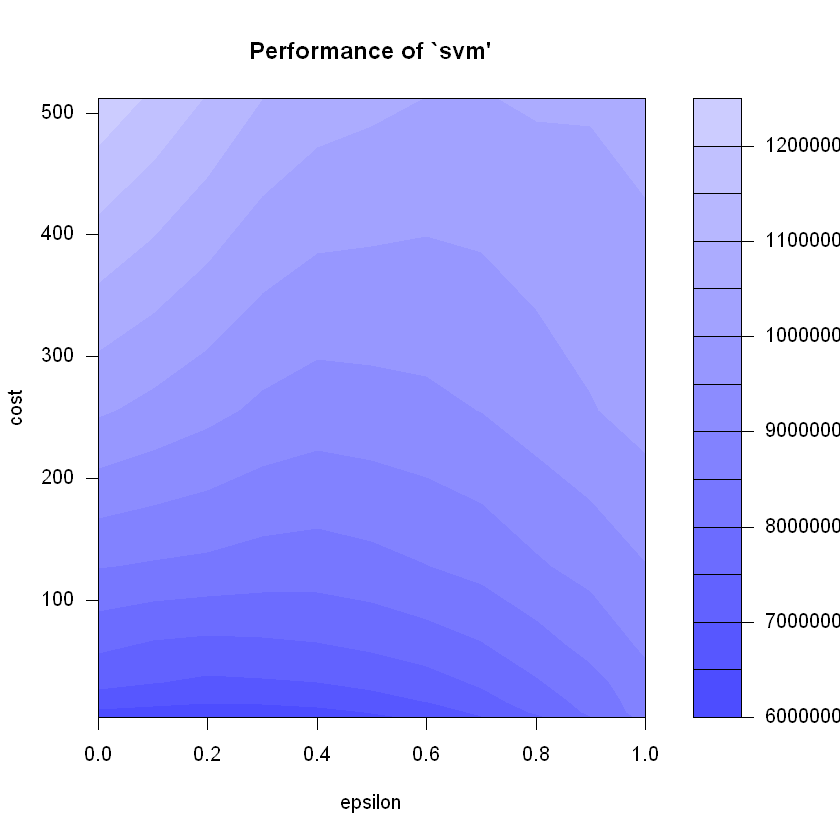

In [32]:
options(warn=-1)
svm.cont.tune <- tune(svm, gross_2016~., data = train_svm,
              ranges = list(epsilon = seq(0,1,0.1), cost = 2^(2:9))
)
options(warn = 1)
print(svm.cont.tune)
plot(svm.cont.tune)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
     0.3    2

- best performance: 6144850702414798 



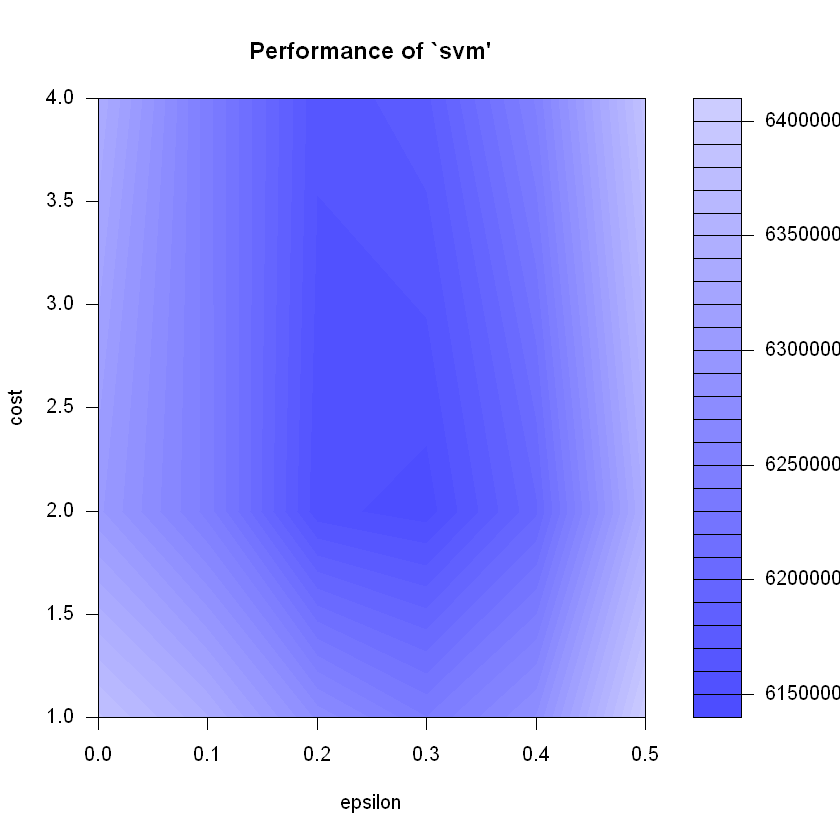

In [33]:
options(warn=-1)
svm.cont.tune2 <- tune(svm, gross_2016~., data = train_svm,
              ranges = list(epsilon = seq(0,0.5,0.1), cost = 2^(0:2))
)
options(warn = 1)
print(svm.cont.tune2)
plot(svm.cont.tune2)

In [34]:
svm.cont.tune$best.model


Call:
best.tune(method = svm, train.x = gross_2016 ~ ., data = train_svm, 
    ranges = list(epsilon = seq(0, 1, 0.1), cost = 2^(2:9)))


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  4 
      gamma:  0.08333333 
    epsilon:  0.3 


Number of Support Vectors:  1176


In [35]:
model.svm.cont.tune <- svm.cont.tune$best.model
model.svm.cont.tune.pred <- predict(model.svm.cont.tune, test_svm) 
error <- test_svm$gross_2016 - model.svm.cont.tune.pred  
rmse(error) 

[1] 86670202

Adding features to the model didn't help to reduce the root mean square error of the model. So for now, a rmse of 85383309 is the mark to beat with the other algorithm.

# Regression with XGBoost
Now we will try regression with the XGBoost algorithm. This algorithm has for advantage to be really fast, he can handle very well sparse matrix and missing data which are present in the IMDB data set.

Since most variables in the data set are not correlated to the variable of interest, using all of them in the model is not really a good idea: it will just add a lot of noise to the model and can create some overfitting problems. But this algorithm picks features according to their importance in the model and since he is so fast, I took the opposite approach I used for the SVM algorithm: I use the most features possible for my first use of this algorithm and I will prune the feature as I go on.

In [36]:
variable_names <- names(train[,!c("budget","gross","profit","budget_us","currency","imdb_score","director_name",
                                  "num_user_for_reviews","movie_imdb_link","num_voted_users","num_critic_for_reviews",
                                  "movie_facebook_likes","genres","movie_title","plot_keywords","actor_1_name",
                                 "actor_2_name","actor_3_name","V1")])

In [37]:
train_xgb<-train[,variable_names,with=FALSE]
test_xgb<-test[,variable_names,with=FALSE]

Since I already coded the categorical variables as dummy variables, I excluded them from the data sets.

In [38]:
train_xgb <- train_xgb[,!cath_var,with=FALSE]
test_xgb <- test_xgb[,!cath_var,with=FALSE]

Then I normalize the continuous variables and coded the missing information. 

In [39]:
for (f in intersect(variable_names,cont_var)) {
  if (max(train_xgb[[f]],na.rm=TRUE)!=1 | min(train_xgb[[f]],na.rm=TRUE)!=0) {
    train_xgb[[f]] <- scale(train_xgb[[f]])
    test_xgb[[f]]  <- scale(test_xgb[[f]])
  }
}

train_xgb[is.na(train_xgb)]<--1
test_xgb[is.na(test_xgb)]<--1

To be able to use XGBoost, I have to feed the function a matrix, so I have to convert the data frame.

In [40]:
drop_col_names <- names(train[,c("gross_2016")])
str(drop_col_names)

 chr "gross_2016"


In [41]:
train_xgb_matrix <- xgb.DMatrix(data.matrix(train_xgb[,!drop_col_names,with=FALSE]),
                                label=train_xgb$gross_2016,missing=-1)
test_xgb_matrix  <- xgb.DMatrix(data.matrix(test_xgb[,!drop_col_names,with=FALSE]),
                                label=test_xgb$gross_2016,missing=-1)

Then I set the parameters for the algorithm. Since the data is normalized, I'm not interested in having the rmse printed for each iteration of the algorithm, so I didn't initialise the Watchlist argument. Also, after trial and error, I realised that 500 iterations were enough for this data.

In [42]:
param <- list(  objective           = "reg:linear", 
                booster             = "gblinear",
                eval_metric         = "rmse"
                )

In [43]:
set.seed(383)
model_xgb <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    nrounds               = 500,
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    missing               = -1,
                    maximize              = FALSE)

Next I took the model created by the algorithm and predicted how much money each movie in the dataset should make at the box-office and compare those predictions with the real values from the test set. To do so, I scale the prediction to match the data set and calculated the rmse.

In [44]:
pred<-predict(model_xgb,test_xgb_matrix)

In [45]:
scaleList <- list(scale = attr(train_xgb$gross_2016, "scaled:scale"),
    center = attr(train_xgb$gross_2016, "scaled:center"))

pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 95480907

In [46]:
xgb.save(model_xgb,fname="model_xgb_1_tune")

[1] TRUE

This model did worse than the best SVM model: maybe the categorical variables don't offer useful information to the algorithm. In the next model, I'll use only the continuous variables that I choose for the last model.

In [47]:
train_xgb <- train_xgb[,intersect(variable_names,cont_var),with=FALSE]
test_xgb <- test_xgb[,intersect(variable_names,cont_var),with=FALSE]

In [48]:
train_xgb_matrix <- xgb.DMatrix(data.matrix(train_xgb[,!drop_col_names,with=FALSE]), label=train_xgb$gross_2016,missing=NA)
test_xgb_matrix  <- xgb.DMatrix(data.matrix(test_xgb[,!drop_col_names,with=FALSE]), label=test_xgb$gross_2016,missing=NA)

In [49]:
set.seed(383)
model_xgb <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    nrounds               = 1000, # changed from 300
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    #watchlist             = watchlist,
                    missing               = -1,
                    maximize              = FALSE)

In [50]:
pred<-predict(model_xgb,test_xgb_matrix)
pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83958476

In [51]:
xgb.save(model_xgb,fname="model_xgb_cont_var")

[1] TRUE

Dropping the categorical variables help the XGBoost algorithm greatly! Let's see if using even less variable will help us make a better model. For the next model, I used only the variables whom were at least mildly correlated with the "gross_2016" variable.

In [52]:
min_var<-names(movies[,c("budget_2016","gross_2016","dir_mean_gross","act_1_mean_gross","act_2_mean_gross","act_3_mean_gross")])

In [53]:
train_xgb <- train_xgb[,min_var,with=FALSE]
test_xgb <- test_xgb[,min_var,with=FALSE]

In [54]:
train_xgb_matrix <- xgb.DMatrix(data.matrix(train_xgb[,!drop_col_names,with=FALSE]), label=train_xgb$gross_2016,missing=NA)
test_xgb_matrix  <- xgb.DMatrix(data.matrix(test_xgb[,!drop_col_names,with=FALSE]), label=test_xgb$gross_2016,missing=NA)

In [55]:
set.seed(383)
model_xgb_tune_1 <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    nrounds               = 1000, # changed from 300
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    #watchlist             = watchlist,
                    missing               = -1,
                    maximize              = FALSE)

In [56]:
pred<-predict(model_xgb_tune_1,test_xgb_matrix)
pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83748393

This model is the more efficient, so far, but I used almost only the default parameter of the XGBoost algorithm to do it. By tuning the hyperparameter I should be able to make a more efficient model to predict the gross of the movie in the test set. In the cell below, I calculated the rmse of different model using a value of eta from 0 to 0.99 by 0.01 increments. The cross validation is made using a 5 fold cross validation.

In [57]:
xgb_mse<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,0.99,0.01)){
    set.seed(383)
     model_xgb_cv <- xgb.cv(params=param, eta=i, data = train_xgb_matrix, nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse<-rbind(xgb_mse,c("index"=i,lapply( model_xgb_cv,function(x) mean(x))))
}

In [123]:
xgb_mse_plot<-plot_ly(xgb_mse) %>%
add_trace(x=~index,y=~test.rmse.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the rmse during the cross validation',
         xaxis = list(title = 'eta', zeroline = TRUE),
         yaxis = list(title = 'rmse'))
embed_notebook(xgb_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_mse_plot",".html"))

In [59]:
xgb_mse[xgb_mse$test.rmse.mean==min(xgb_mse$test.rmse.mean,na.rm=TRUE),]

,index,train.rmse.mean,train.rmse.std,test.rmse.mean,test.rmse.std
67,0.66,0.7717064,0.0302158,0.7675378,0.1186582


Now that I have the value of the eta that minimise the rmse of the test set used in the cross validation, I can create a more efficient model.

In [60]:
set.seed(383)
model_xgb_tune_2 <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    eta                   = 0.66,
                    nrounds               = 500,
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    missing               = -1,
                    maximize              = FALSE)

In [61]:
pred<-predict(model_xgb_tune_2,test_xgb_matrix)
pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83748393

In [124]:
xgb_pred<-plot_ly(test_xgb) %>%
add_trace(y=~test$gross_2016, 
          name = 'test set', type = 'scatter',mode = 'lines+markers' )%>%
add_trace(y=~pred_unscale ,name = 'predictions', type = 'scatter',mode = 'markers' )%>%
layout(title = 'Gross revenu of movies in the data set and prediction made with the XGBoost algorithm',
         xaxis = list(title = '', zeroline = TRUE),
         yaxis = list(title = 'Gross'))

embed_notebook(xgb_pred,file=paste0("plotlyJupyterHTML/","xgb_pred",".html"))

In [63]:
xgb.save(model_xgb,fname="model_xgb_min_var")

[1] TRUE

# Classification
## XGBoost logistic regression

By zooming on any part of the last plot, we see that regression with the XGBoost algorithm has trouble adjusting to the variability of the data, i.e. the algorithm underestimate the profit of a high margin movie and overestimate the performance of the movie who lost a lot of money. If we simplify our goal and only are interested to know if the movie will be profitable, does the model will be more accurate? First, let us look at the previous results.

In [64]:
prediction<-test[,c("gross_2016","budget_2016","profit")]
prediction$pred_gross<-error
prediction$pred_profit<-prediction$pred_gross-prediction$budget_2016
prediction$pred_profit_binary<-0
prediction[prediction$pred_profit*prediction$profit>0, "pred_profit_binary"]<-1

sum(prediction[complete.cases(prediction),"pred_profit_binary"])/nrow(prediction[complete.cases(prediction),])

[1] 0.554491

The previous model sort correctly about half of the observations in the test set. Not bad, but we can do better by using an algorithm tailor made for that classification. The first one I used is the XGBoost for logistic regression.

As usual, I started by creating a modified train and test set to use with the algorithm. 

In [65]:
variable_names_log <- names(train[,!c("budget","gross","gross_2016","budget_us","currency","imdb_score","director_name",
                                  "num_user_for_reviews","movie_imdb_link","num_voted_users","num_critic_for_reviews",
                                  "movie_facebook_likes","genres","movie_title","plot_keywords","actor_1_name",
                                 "actor_2_name","actor_3_name","V1")])

train_xgb_log<-train[,variable_names_log,with=FALSE]
test_xgb_log<-test[,variable_names_log,with=FALSE]

train_xgb_log <- train_xgb_log[,!cath_var,with=FALSE]
test_xgb_log <- test_xgb_log[,!cath_var,with=FALSE]

for (f in intersect(variable_names_log,cont_var)) {
  if (max(train_xgb_log[[f]],na.rm=TRUE)!=1 | min(train_xgb_log[[f]],na.rm=TRUE)!=0) {
    train_xgb_log[[f]] <- scale(train_xgb_log[[f]])
    test_xgb_log[[f]]  <- scale(test_xgb_log[[f]])
  }
}

train_xgb_log[is.na(train_xgb_log)]<--1
test_xgb_log[is.na(test_xgb_log)]<--1

Then I create a new variable "profitable" who indicate if the movie was profitable or not.

In [66]:
train_xgb_log$profitable<-0
test_xgb_log$profitable<-0

train_xgb_log[which(train_xgb_log$profit>=0),"profitable"]<-1
test_xgb_log[which(test_xgb_log$profit>=0),"profitable"]<-1

Then I repeat the steps use for the regression with XGBoost, but I changed the objective for the logistic regression and the evaluation metric for the binary classification error rate.

In [67]:
train_xgb_log_mat <- xgb.DMatrix(data.matrix(train_xgb_log[,!c("profitable","profit"),with=FALSE]), label=train_xgb_log$profitable,missing=-1)
test_xgb_log_mat <- xgb.DMatrix(data.matrix(test_xgb_log[,!c("profitable","profit"),with=FALSE]), label=test_xgb_log$profitable,missing=-1)

In [68]:
param <- list(  objective           = "binary:logistic",
                eval_metric         = "error")

In [69]:
set.seed(383)
model_xgb_log <- xgb.train(   params        = param, 
                    data                = train_xgb_log_mat, 
                    nrounds             = 500,
                    verbose             = 0, 
                    missing             =-1,
                    maximize            = FALSE)

Having made the model, I have to make the prediction over the test set and calculate the binary error rate.

In [70]:
prediction<-data.frame(profit=test_xgb_log$profitable)
prediction$output<-NA

In [71]:
for (rows in split(1:nrow(test_xgb), ceiling((1:nrow(test_xgb))/10000))) {
    prediction[rows, "output"] <- predict(model_xgb_log, test_xgb_log_mat)
    }

In [72]:
prediction$pred<-0
prediction[which(prediction$output>=0.5),"pred"]<-1
prediction$index<-seq.int(nrow(prediction))
head(prediction)

profit,output,pred,index
0,0.000003818766799668,0,1
0,0.000000000203112957,0,2
0,0.000347295281244442,0,3
0,0.001790401292964816,0,4
0,0.999916315078735352,1,5
0,0.000000000002252107,0,6


In [73]:
prediction<-prediction[!is.na(test$gross_2016),]
result<-table(prediction$profit,prediction$pred)
result

   
      0   1
  0 565  54
  1 179  65

In [74]:
print(paste0("Accuracy: ",(result[1,1]+result[2,2])/sum(result)))
print(paste0("Precision: ",(result[2,2])/(result[2,2]+result[2,1])))
print(paste0("Recall: ",(result[2,2])/(result[2,2]+result[1,2])))

[1] "Accuracy: 0.730011587485516"
[1] "Precision: 0.266393442622951"
[1] "Recall: 0.546218487394958"


We can see that this model is more accurate to classify the movies than the regression algorithm from the last section, but not by much. In fact, our model has trouble to classify correctly the profitable movies and tend to overclassify the movie in the non-profitable category. The table above shows me that a model who would classify all the movie in the data set as non-profitable would have about 55% accuracy which is not that much less than this model. 

Maybe tuning and simplifying the model will help improve the precision of the model. Let us look at the contribution to the model of each individual model.

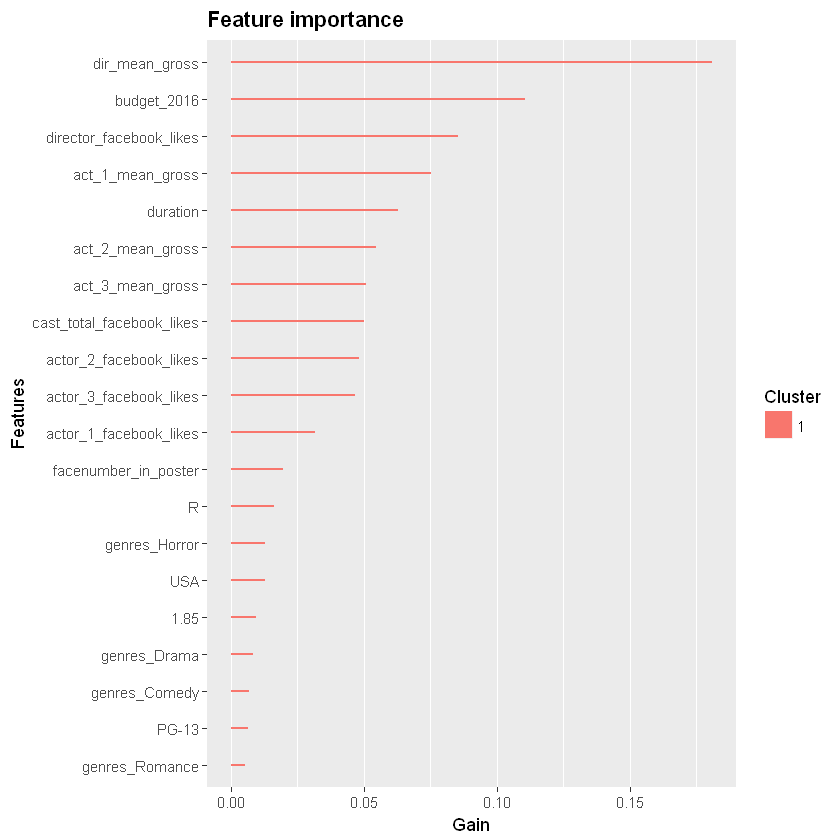

In [75]:
importance_matrix <- xgb.importance(dimnames(train_xgb_log[,!c("profitable","profit"),with=FALSE])[[2]], model = model_xgb_log)
xgb.plot.importance(importance_matrix[1:20])

We can see that most of the 274 variables have little or no influence on the model. In consequence, I will keep only the 20 variables with the most importance. 

In [76]:
names_var_log<-c(importance_matrix[1:30,Feature],"profitable","profit")
train_xgb_log<-train_xgb_log[,names_var_log,with=FALSE]
test_xgb_log<-test_xgb_log[,names_var_log,with=FALSE]

In [77]:
train_xgb_log_mat <- xgb.DMatrix(data.matrix(train_xgb_log[,!c("profitable","profit"),with=FALSE]), 
                                 label=train_xgb_log$profitable,missing=-1)
test_xgb_log_mat <- xgb.DMatrix(data.matrix(test_xgb_log[,!c("profitable","profit"),with=FALSE]), 
                                label=test_xgb_log$profitable,missing=-1)

Then I do a cross validation to determine which value of the hyperparameter to use with the algorithm. I started by the ETA.

### ETA

The eta is a parameter that prevents overfitting by scaling down the weight of each feature after each iteration. I used a 5 fold cross validation process with 5 rounds after which the averages of the mean error are calculated for the prediction of the train a test set.

In [126]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,0.99,0.01)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=i, data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [80]:
head(xgb_mse_log)

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
2,0.00,0.2687690,0.0030040,0.2687650,0.0120120
21,0.01,0.2106102,0.0053150,0.2681410,0.0089248
3,0.02,0.2093326,0.0061988,0.2669412,0.0091132
4,0.03,0.2079380,0.0070086,0.2673060,0.0083570
5,0.04,0.2055914,0.0078950,0.2664192,0.0101324
6,0.05,0.2041578,0.0088464,0.2653764,0.0110574


The plot below shows the average mean classification error for the prediction of the test set made with different value of eta from 0 to 1. 

In [127]:
xgb_log_eta_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the eta parameter',
         xaxis = list(title = 'eta', zeroline = TRUE),
         yaxis = list(title = 'rmse'))
embed_notebook(xgb_log_eta_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_eta_mse_plot",".html"))

In [128]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
45,0.44,0.1779068,0.0050786,0.2552106,0.0093492


Since the value of the parameter eta who minimise the mean error is 0.4 that is the value I'll use for the model.

### Alpha

Alpha is a regularization term use in the linear version of XGBoost. To find the most appropriate value to use in the model, I used the same cross validation process than before.

In [83]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,20,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.44, alpha = i, 
                                data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [87]:
xgb_log_alpha_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the alpha parameter',
         xaxis = list(title = 'Alpha', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_alpha_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_mse_alpha_plot",".html"))

In [85]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
40,3.9,0.1948644,0.0044528,0.2474418,0.009387


### Lambda

Like alpha, lambda is another regularization parameter that prevent overfitting problem.

In [86]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,10,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 3.9, lambda=i,
                                data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [88]:
head(xgb_mse_log)

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
2,0.0,0.1930528,0.0035864,0.2527058,0.0126518
21,0.1,0.1929874,0.0035914,0.2517150,0.0127060
3,0.2,0.1932742,0.0037084,0.2539572,0.0130306
4,0.3,0.1936132,0.0035516,0.2543218,0.0135720
5,0.4,0.1931176,0.0039812,0.2530710,0.0127222
6,0.5,0.1939650,0.0032350,0.2524460,0.0115320


In [95]:
xgb_log_lambda_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the lambda parameter',
         xaxis = list(title = 'Lambda', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_lambda_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_lambda_plot",".html"))

In [96]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
23,2.2,0.2130214,0.0051100,0.2463468,0.0111840
25,2.4,0.2142726,0.0053868,0.2463468,0.0112264


### gamma 

This parameter is the minimum loss reduction that need to occur for the partition of a tree. That parameter can take any value greater or equal to 0 and the greater the value, the more conservative the model will be.  

In [98]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,10,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha =3.9, lambda=2.2,
                                gamma=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [99]:
xgb_log_gamma_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the gamma parameter',
         xaxis = list(title = 'Gamma', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_gamma_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_gamma_plot",".html"))

In [100]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
56,5.5,0.2236188,0.0056596,0.2468158,0.0117578


### max_depth

As his name indicates that a parameter set the maximum depth of each tree. This parameter takes value greater or equal to 1.

In [101]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(1,50,1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha =3.9, lambda=2.2,
                                gamma=5.5,max_depth=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [102]:
xgb_log_max_depth_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the max_depth parameter',
         xaxis = list(title = 'max_depth', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_max_depth_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_max_depth_plot",".html"))

In [103]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
6,6,0.2236188,0.0056596,0.2468158,0.0117578


As 6 is the default value of the parameter max_depth and that value minimise the mean error during the cross validation, I didn't change the default value.

### min_child_weight

This parameter determines the minimum weight that can have a tree after a partition during the creation of the model. Before each partition, the algorithm verify if the resulting child tree would have a weight smaller than that value and if it's the case, he doesn't do the partition. This parameter can take values greater than 0 and the bigger the value the more conservative the model will be.

In [104]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,150,0.5)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha =3.9, lambda=2.2,
                                gamma=5.5,min_child_weight=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [105]:
xgb_log_min_child_weight_expl<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the min_child_weight parameter',
         xaxis = list(title = 'min_child_weight', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_min_child_weight_expl,file=paste0("plotlyJupyterHTML/","xgb_log_min_child_weight_expl",".html"))

We see that there a minimum around min_child_weight=0, so I focus on this area of the graph.

In [106]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,5,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha =3.9, lambda=2.2,
                                gamma=0.1,min_child_weight=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [107]:
xgb_log_min_child_weight_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the min_child_weight parameter',
         xaxis = list(title = 'min_child_weight', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_min_child_weight_plot,file=paste0("plotlyJupyterHTML/","xgb_log_min_child_weight_plot",".html"))

In [108]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
17,1.6,0.1959332,0.0042286,0.2496824,0.01162


Since all those values would minimise the mean classification error, I used min_child_weight=1.6.

### max_delta_step

max_delta_step is the maximum variation of the weight that we allow between two iterations of the algorithm. This value could be 0 (no constraint) or greater (more conservative).  

In [109]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,10,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha =3.9, lambda=2.2,
                                gamma=0.1,min_child_weight=1.6,max_delta_step=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [110]:
xgb_log_max_delta_step_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the max_delta_step parameter',
         xaxis = list(title = 'max_delta_step', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_max_delta_step_plot,file=paste0("plotlyJupyterHTML/","xgb_log_max_delta_step_plot",".html"))

Since the default value of the parameter gives the minimum me an error, I won't modify this value in the function.
### subsample
This is the ratio of the sample during the training of the model. This parameter can take values between 0 and 1 (included).

In [111]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,1,0.01)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha =3.9, lambda=2.2,
                                gamma=0.1,min_child_weight=1.6,max_delta_step=1.1,min_child_weight=62, 
                                subsample=i,data = train_xgb_log_mat,
                                eval_metric= "error",nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [112]:
xgb_log_subsample_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the subsample parameter',
         xaxis = list(title = 'subsample', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_subsample_plot,file=paste0("plotlyJupyterHTML/","xgb_log_subsample_plot",".html"))

In [114]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
98,0.97,0.2397416,0.0031538,0.2485894,0.0095586


Now that I know which value of the hyperparameter to use, I can test the new model.

In [129]:
param_tune <- list(     objective= "binary:logistic", 
                        eta=0.4,
                        alpha = 3.9, 
                        lambda=2.2,
                        gamma=0.1, 
                        min_child_weight=1.6,
                        max_delta_step=1.1,
                        min_child_weight=62,
                        subsample=0.97, 
                        colsample_bytree=1                
                )

In [130]:
set.seed(383)
model_xgb_log_tune <- xgb.train(    params              = param_tune, 
                                    data                = train_xgb_log_mat, 
                                    nrounds             = 500, 
                                    eval_metric         = "error", 
                                    missing             =-1,
                                    verbose             = 0,
                                    maximize            = FALSE)

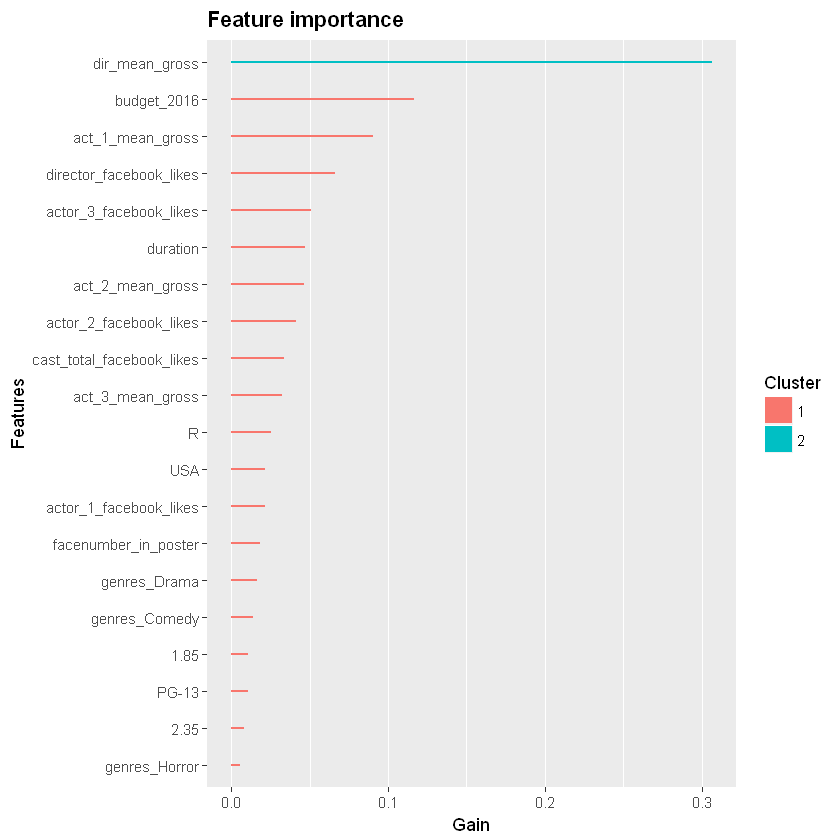

In [136]:
importance_matrix <- xgb.importance(dimnames(train_xgb_log[,!c("profitable","profit"),with=FALSE])[[2]],
                                    model =model_xgb_log_tune)
xgb.plot.importance(importance_matrix[1:20])

We can see the previous success of a director is the most important factor for the profitability of a movie, follow by the budget of the movie, then by the previous success of the main actor. Let's see if the model is able to classify effectively the movie in the test data set.

In [131]:
prediction<-data.frame(profit=test_xgb_log$profitable)
prediction$output<-NA

In [132]:
for (rows in split(1:nrow(test_xgb), ceiling((1:nrow(test_xgb))/10000))) {
    prediction[rows, "output"] <- predict(model_xgb_log_tune, test_xgb_log_mat)
    }

In [133]:
prediction$pred<-0
prediction[which(prediction$output>=0.5),"pred"]<-1
prediction$index<-seq.int(nrow(prediction))
prediction<-prediction[!is.na(test$gross_2016),]

result<-table(prediction$profit,prediction$pred)
result

   
      0   1
  0 560  59
  1 174  70

In [134]:
print(paste0("Accuracy: ",(result[1,1]+result[2,2])/sum(result)))
print(paste0("Precision: ",(result[2,2])/(result[2,2]+result[2,1])))
print(paste0("Recall: ",(result[2,2])/(result[2,2]+result[1,2])))

[1] "Accuracy: 0.730011587485516"
[1] "Precision: 0.286885245901639"
[1] "Recall: 0.542635658914729"


The tuning help improve the precision of the model. 

In [439]:
xgb.save(model_xgb_log,fname="model_xgb_log")

[1] TRUE

# Conclusion

We saw that the regression algorithms were not really accurate in predicting the exact amount of money a movie would make at the box-office, but that the XGBoost algorithm is quite accurate when answering the broader question "Will a movie be profitable or not". 

Part of the reason why the regression algorithm did poorly is because the box-office is very volatile, but also because some important variables were not available in our data set. For example, the marketing budget is not a value disclosed by the movie studios and is a really important factor in the success of a movie. The same thing can be said of the date of release of a movie, the number of movie release that same week, etc. Having access to those data would greatly improve the regression model.

In the context where some important variables are not available, simplifying the model and focusing on the profitability of the movie proved to be a great strategy. The above output shows us that near 73% of the observations are correctly labelled by the model. That is 30% of the profitable movie are correctly labelled and near 90% of the non-profitable movie is correctly labelled.